
# Manual vs scikit-learn K-Means

Import essentials and define a tiny config for a clean, reproducible demo.

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

# Configuration
N_SAMPLES = 100
CENTERS = [[2, 2], [8, 2]]
CLUSTER_STD = 0.6
RANDOM_STATE = 42
N_CLUSTERS = 2
MAX_ITERATIONS = 100


Make a simple two-cluster dataset once so both methods see the exact same points.

In [6]:

X, true_labels = make_blobs(
    n_samples=N_SAMPLES,
    centers=CENTERS,
    cluster_std=CLUSTER_STD,
    random_state=RANDOM_STATE
)
print(f"Data shape: {X.shape}, clusters: {len(np.unique(true_labels))}")


Data shape: (100, 2), clusters: 2


Define the distance and a careful manual K-Means with inertia and silhouette.

In [8]:

def euclidean_distance(p1, p2):
    """Return the Euclidean distance between two points."""
    return np.sqrt(np.sum((p1 - p2)**2))

def manual_kmeans_and_metrics(X, n_clusters, max_iter, random_state, init_centroids=None):
    """Run K-Means from scratch and return labels, centroids, iters, inertia, and silhouette."""
    if init_centroids is not None:
        centroids = init_centroids.copy()
    else:
        np.random.seed(random_state)
        centroids = np.random.uniform(
            low=X.min(axis=0), high=X.max(axis=0), size=(n_clusters, X.shape[1])
        )
    for i in range(max_iter):
        labels = np.array([np.argmin([euclidean_distance(point, c) for c in centroids]) for point in X])
        new_centroids = []
        for k in range(n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                new_centroids.append(X[np.random.randint(len(X))])
        new_centroids = np.array(new_centroids)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    num_iterations = i + 1
    manual_inertia = 0.0
    for k in range(n_clusters):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            manual_inertia += np.sum((cluster_points - centroids[k])**2)
    silhouette_vals = []
    for i in range(len(X)):
        my_label = labels[i]
        same_cluster_mask = (labels == my_label) & (np.arange(len(X)) != i)
        same_cluster_points = X[same_cluster_mask]
        if len(same_cluster_points) > 0:
            a_i = np.mean([euclidean_distance(X[i], p) for p in same_cluster_points])
        else:
            a_i = 0.0
        b_i = np.inf
        for k in range(n_clusters):
            if k != my_label:
                other_cluster_points = X[labels == k]
                if len(other_cluster_points) > 0:
                    avg_dist_to_other = np.mean([euclidean_distance(X[i], p) for p in other_cluster_points])
                    b_i = min(b_i, avg_dist_to_other)
        silhouette_vals.append(0.0 if b_i == np.inf else (b_i - a_i) / max(a_i, b_i))
    manual_silhouette = float(np.mean(silhouette_vals))
    return labels, centroids, num_iterations, float(manual_inertia), manual_silhouette


Fix the exact same random centroids so both solvers start identically.

In [10]:

np.random.seed(RANDOM_STATE)
shared_init_centroids = np.random.uniform(
    low=X.min(axis=0), high=X.max(axis=0), size=(N_CLUSTERS, X.shape[1])
)
print(shared_init_centroids)


[[3.68798481 3.49288702]
 [6.79910511 2.49845506]]


Run the manual implementation and capture labels, centroids, iterations, and metrics.

In [12]:

t0 = time.time()
manual_labels, manual_centroids, manual_iters, manual_inertia, manual_sil = manual_kmeans_and_metrics(
    X, N_CLUSTERS, MAX_ITERATIONS, RANDOM_STATE, init_centroids=shared_init_centroids
)
manual_time = time.time() - t0
manual_labels = np.asarray(manual_labels)
manual_centroids = np.asarray(manual_centroids)
print(f"Manual: iters={manual_iters}, inertia={manual_inertia:.2f}, silhouette={manual_sil:.3f}, time={manual_time:.4f}s")


Manual: iters=2, inertia=61.27, silhouette=0.834, time=0.1302s


Run scikit-learn K-Means from the same initial centroids for a fair match.

In [14]:

t0 = time.time()
kmeans_sklearn = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=1,
    init=shared_init_centroids,
    max_iter=MAX_ITERATIONS
).fit(X)
sklearn_time = time.time() - t0

sklearn_labels = kmeans_sklearn.labels_
sklearn_centroids = kmeans_sklearn.cluster_centers_
sklearn_iters = kmeans_sklearn.n_iter_
sklearn_inertia = kmeans_sklearn.inertia_
sklearn_sil = silhouette_score(X, sklearn_labels)
print(f"Sklearn: iters={sklearn_iters}, inertia={sklearn_inertia:.2f}, silhouette={sklearn_sil:.3f}, time={sklearn_time:.4f}s")


Sklearn: iters=2, inertia=61.27, silhouette=0.834, time=0.4802s


C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Print a compact comparison so differences are crystal clear.

In [16]:

print("--- CORRECTED K-Means Implementation Comparison ---")
print(f"{'Metric':<25} | {'Manual K-Means':<20} | {'Scikit-learn K-Means':<20} | {'Difference'}")
print("-" * 85)
print(f"{'Execution Time (s)':<25} | {manual_time:<20.5f} | {sklearn_time:<20.5f} | {abs(manual_time-sklearn_time):.5f}")
print(f"{'Iterations to Converge':<25} | {manual_iters:<20} | {sklearn_iters:<20} | {abs(manual_iters-sklearn_iters)}")
print(f"{'Final Inertia':<25} | {manual_inertia:<20.2f} | {sklearn_inertia:<20.2f} | {abs(manual_inertia-sklearn_inertia):.2f}")
print(f"{'Silhouette Score':<25} | {manual_sil:<20.4f} | {sklearn_sil:<20.4f} | {abs(manual_sil-sklearn_sil):.4f}")
print("-" * 85)

centroid_diff = float(np.max(np.abs(manual_centroids - sklearn_centroids)))
labels_equal = bool(np.array_equal(manual_labels, sklearn_labels))
print(f"Max centroid difference: {centroid_diff:.6f}")
print(f"Labels match exactly: {labels_equal}")


--- CORRECTED K-Means Implementation Comparison ---
Metric                    | Manual K-Means       | Scikit-learn K-Means | Difference
-------------------------------------------------------------------------------------
Execution Time (s)        | 0.13016              | 0.48024              | 0.35008
Iterations to Converge    | 2                    | 2                    | 0
Final Inertia             | 61.27                | 61.27                | 0.00
Silhouette Score          | 0.8344               | 0.8344               | 0.0000
-------------------------------------------------------------------------------------
Max centroid difference: 0.000000
Labels match exactly: True


Visualize the manual result with data colored by cluster and distinct markers for centroids.

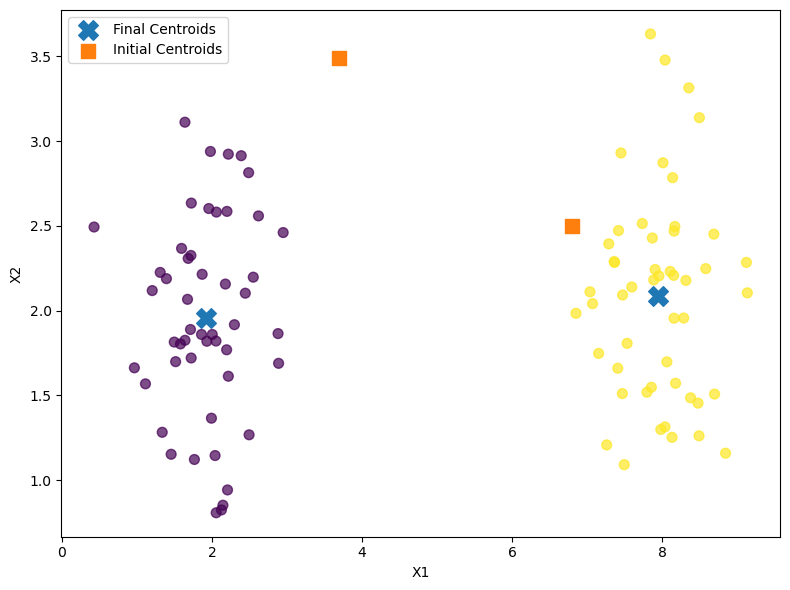

In [18]:

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=manual_labels, s=50, alpha=0.7)
plt.scatter(manual_centroids[:, 0], manual_centroids[:, 1], marker='X', s=200, label='Final Centroids')
plt.scatter(shared_init_centroids[:, 0], shared_init_centroids[:, 1], marker='s', s=100, label='Initial Centroids')
plt.xlabel('X1'); plt.ylabel('X2')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Visualize the scikit-learn result the same way so the comparison stays apples-to-apples.

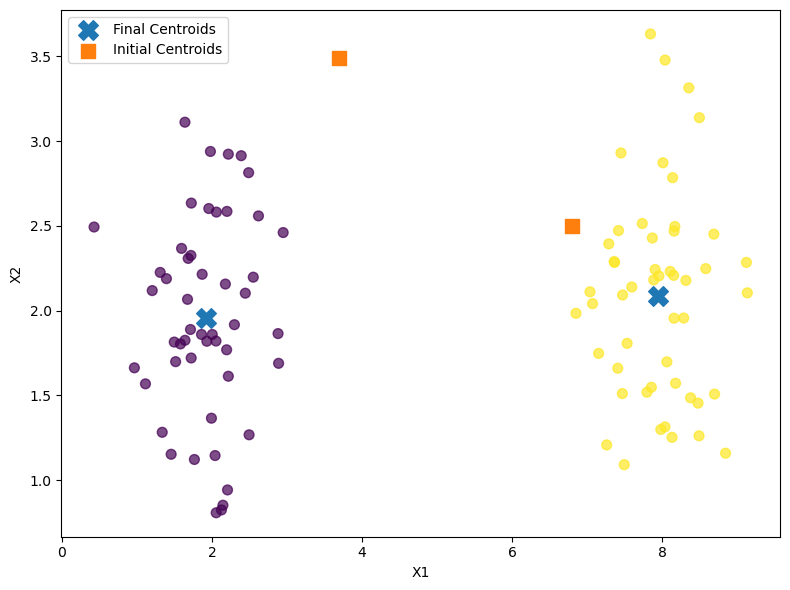

In [20]:

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels, s=50, alpha=0.7)
plt.scatter(sklearn_centroids[:, 0], sklearn_centroids[:, 1], marker='X', s=200, label='Final Centroids')
plt.scatter(shared_init_centroids[:, 0], shared_init_centroids[:, 1], marker='s', s=100, label='Initial Centroids')
plt.xlabel('X1'); plt.ylabel('X2')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Same init, same data, same stopping rules — the rest is implementation details.